In [1]:
import sys
import os
import numpy as np
import scipy.interpolate as interpolate
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_palette("colorblind")


In [2]:
# For fitting the light curves
from gatspy import periodic
from astroML import time_series

In [3]:
sys.path.extend(['/Users/lynnej/otherRepos/CometGPs/notebooks'])
import alcdef_util as au

In [4]:
# Where is your data from ALCDF?
ddir = '/Users/lynnej/otherRepos/translate-cuss/alcdef_data'

ALCDEF_16_Psyche_20180207_185754 block 0: (midpoint 2015-11-30, 09:44:00)
Observed in C, reporting V
Reported differential magnitudes
Times are light time corrected by -0.009812 (AVERAGE)
ALCDEF_16_Psyche_20180207_185754 block 1: (midpoint 2015-12-01, 09:02:00)
Observed in C, reporting V
Reported differential magnitudes
Times are light time corrected by -0.009806 (AVERAGE)
ALCDEF_16_Psyche_20180207_185754 block 2: (midpoint 2015-12-26, 06:16:00)
Observed in V, reporting V
Reported differential magnitudes
Times are light time corrected by -0.010166 (AVERAGE)


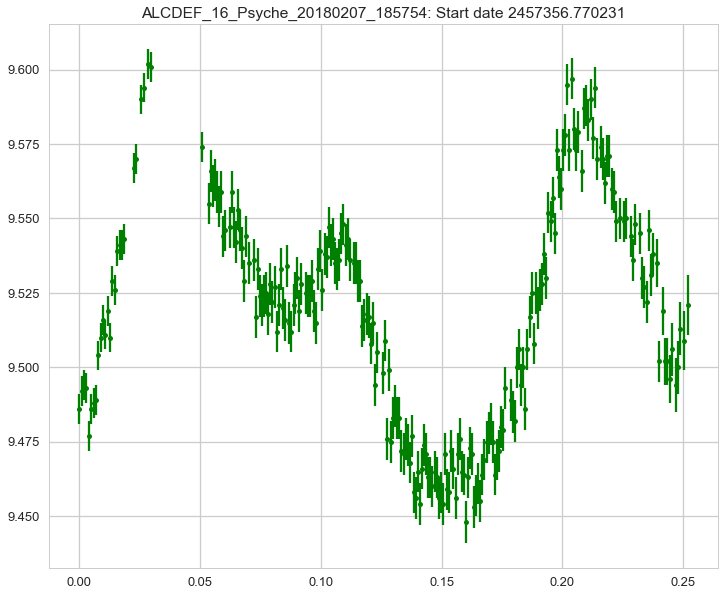

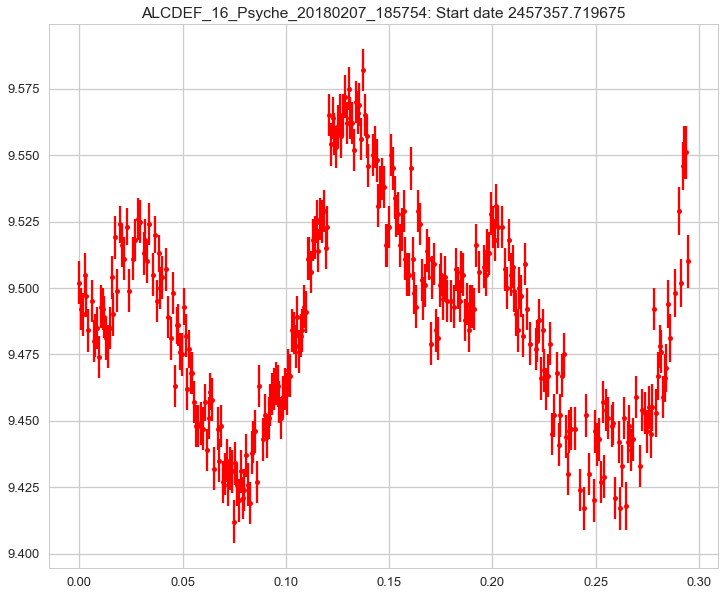

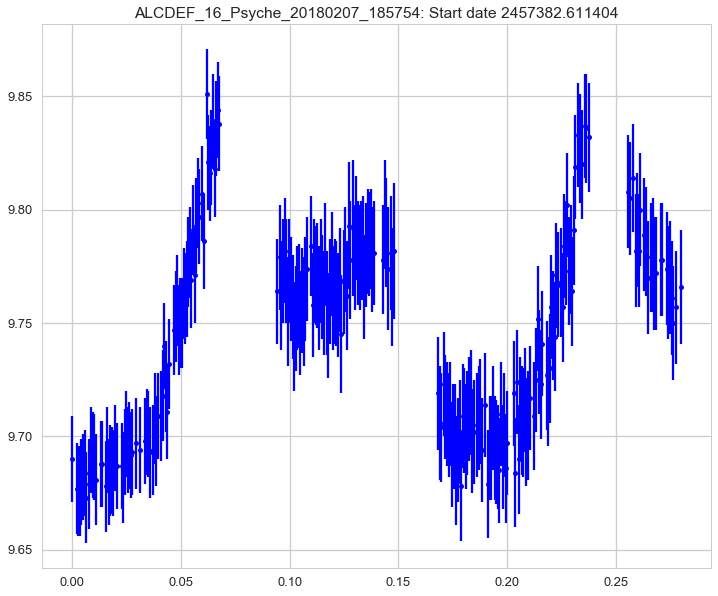

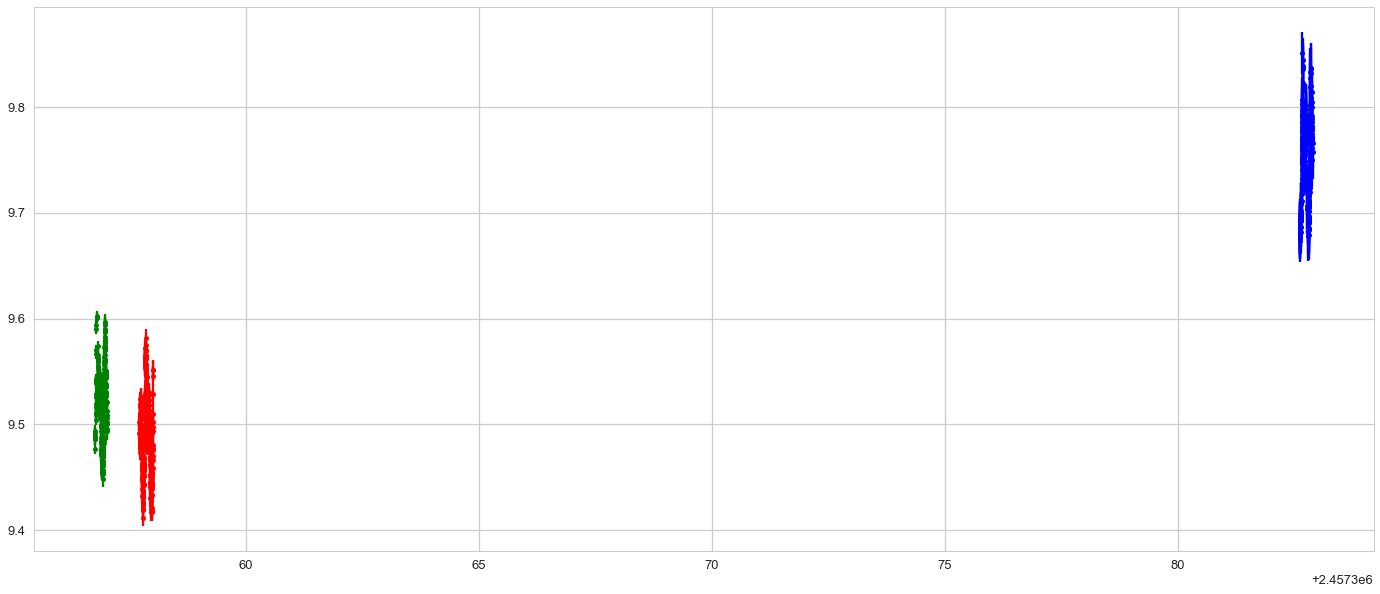

In [5]:
# Picked the Psyche LC data - they have two segments.
fname = 'ALCDEF_16_Psyche_20180207_185754.txt'
md, lc = au.read_alcdef(os.path.join(ddir, fname))
au.plot_lightcurve(md, lc, fname)

In [6]:
# Fit the LC data. "xi" gives me a way to hack the starting point, so that the end/start of the fit match up
# reasonably .. not perfectly though. (yes, this is a hack)
tstep = 0.5/60/24
xi = 14
fit_x = lc[0].JD.values[xi:] 
fit_y = lc[0].Mag.values[xi:]
f = interpolate.splrep(fit_x - fit_x[0], fit_y - fit_y[0], s=0.013)

(2457356.7702310001, 2457357.0222089998)

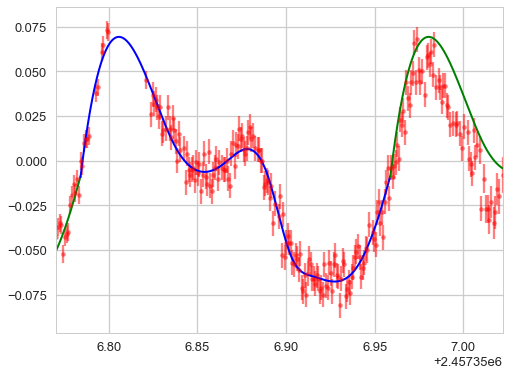

In [7]:
# The LCDB says Psyche has a rotation period of 4.196 HRs, so I'll use that for the period.
# I am a little confused on whether this is truly the rotation period or light curve period ... 
# Clearly there are two different peaks within this period, so that would indicate rotation period I think.
# But the second peak is so small..
# Chunk 1 
i = 0
period = 4.196/24.0
plt.figure(figsize=(8, 6))
plt.errorbar(lc[i].JD, lc[i].Mag - lc[i].Mag[xi], yerr=lc[i].DeltaMag, color='r', linestyle='', marker='.', alpha=0.5)
times = np.arange(0, period, 1/24./60./60.0)
offset = lc[0].JD[xi]
plt.plot(times + offset - period, interpolate.splev(times, f, der=0), color='g', linewidth=2)
plt.plot(times + offset, interpolate.splev(times, f, der=0), color='b', linewidth=2)
plt.plot(times + offset + period, interpolate.splev(times, f, der=0), color='g', linewidth=2)
plt.xlim(lc[i].JD.min(), lc[i].JD.max())

(2457357.7196749998, 2457358.0143320002)

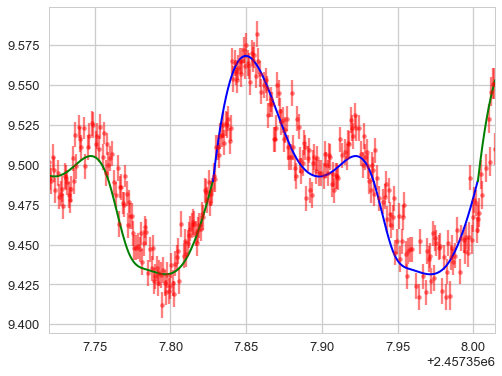

In [8]:
# Chunk 2 for verification
i = 1
offset = lc[i].JD[0] + period * 0.62
magoffset = lc[0].Mag[xi] - 0.03
plt.figure(figsize=(8, 6))
plt.errorbar(lc[i].JD, lc[i].Mag, yerr=lc[i].DeltaMag, color='r', linestyle='', marker='.', alpha=0.5)
plt.plot(times + offset - period, interpolate.splev(times, f, der=0) + magoffset, color='g', linewidth=2)
plt.plot(times + offset, interpolate.splev(times, f, der=0) + magoffset, color='b', linewidth=2)
plt.plot(times + offset + period, interpolate.splev(times, f, der=0) + magoffset, color='g', linewidth=2)
plt.xlim(lc[i].JD.min(), lc[i].JD.max())

Text(0,0.5,'Delta Magnitude')

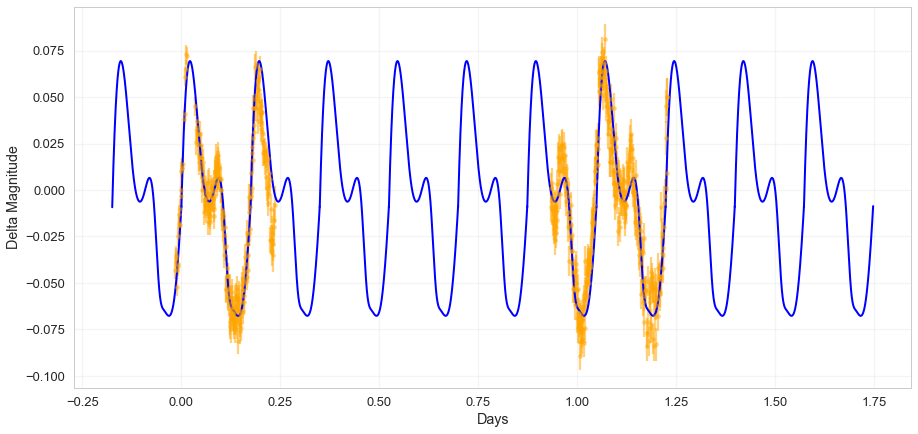

In [9]:
# This is two observing nights. Interesting to clearly see the number of unobserved rotations, no?
plt.figure(figsize=(15, 7))
offset = 0 
tstart = lc[0].JD[16]
for p in range(-1, 10):
    plt.plot(times + offset + p * period, interpolate.splev(times, f, der=0), color='b', linewidth=2)
i = 0
magoffset = - lc[i].Mag[xi]
plt.errorbar(lc[i].JD - tstart, lc[i].Mag + magoffset, yerr=lc[i].DeltaMag, color='orange', 
             linestyle='', marker='.', alpha=0.5)
i = 1
magoffset =  - lc[i].Mag[xi] - 0.02
plt.errorbar(lc[i].JD - tstart, lc[i].Mag + magoffset, yerr=lc[i].DeltaMag, color='orange', 
             linestyle='', marker='.', alpha=0.5)
plt.grid(True, alpha=0.2)
plt.xlabel('Days')
plt.ylabel('Delta Magnitude')

In [10]:
# simulate about 30 distinct nights of ZTF data (which would cross about 60 nights or so of time)

def spline_template(t, period=4.196/24.0, fudge=1.0):
    y = fudge * interpolate.splev(t % period, f, der=0)
    return y
    
def simulate_ZTF(lightcurve_template, mag_err=0.03, fudge=1.0, period=4.196/24.0):
    # Simulate ZTF visits
    ztf_times = []
    nnights = 30
    dnights = np.random.randint(3, 6, size=nnights)
    dnights[1::2] = 0 
    nights = np.zeros(nnights, float) + dnights
    nights = nights.cumsum()
    # After 1 month, given field rises 2 hours earlier
    # Let's say we start @ +/- 1 hour of midnight
    start_times = (np.random.random(nnights) * 2.0 - 1.0) * 60.0
    start_times[::2] = start_times[1::2]
    dtimes = np.random.randint(30, 51, size=nnights)
    dtimes[::2] = 0
    times = nights + (start_times  + dtimes) / 60.0 /  24.0 + (nights * -2./24./30.)
    true_mags = lightcurve_template(times, fudge=fudge, period=period)
    applied_mag_errs = np.random.normal(0, mag_err, size=len(times))
    mags = true_mags + applied_mag_errs
    mag_errs = np.zeros(len(mags), float) + mag_err
    return times, mags, mag_errs, true_mags

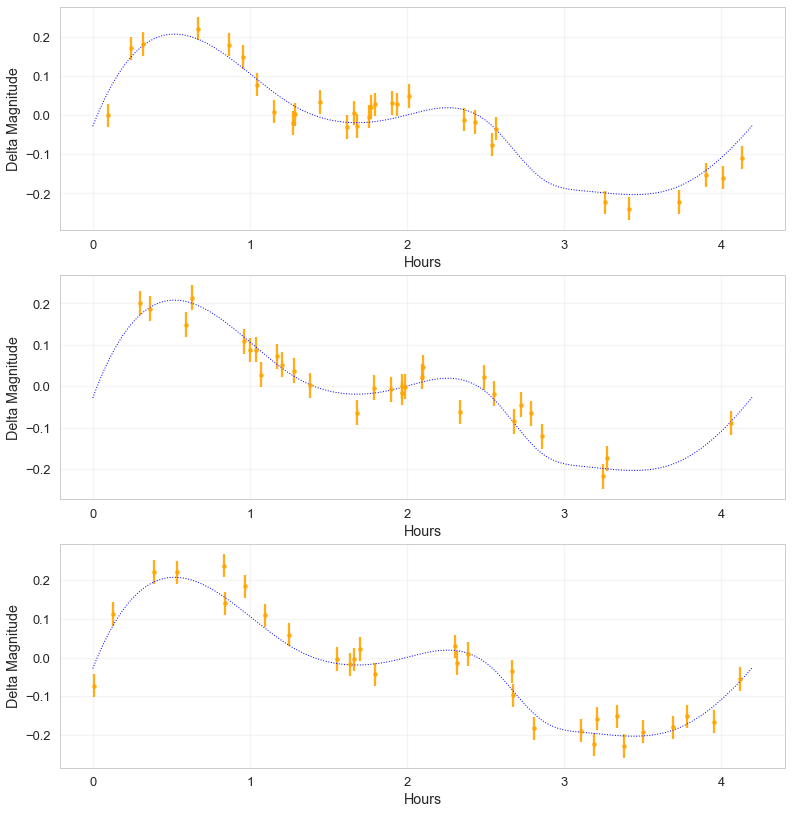

In [11]:
# Plot some instantiations, in a properly phased version.
fudge = 3.0
plt.figure(figsize=(13, 14))
for i in range(3):
    plt.subplot(3,1,i+1)
    tt = np.arange(0, period, 1/24./60./60.0)
    ff = spline_template(tt, fudge=fudge)
    plt.plot(tt*24, ff, 'b', linewidth=1, linestyle=':')
    times, mags, mag_errs, ap_errs = simulate_ZTF(spline_template, fudge=fudge)
    """
    with open('ztf_mags_%d.txt' % i, 'w') as zout:
        zout.write('Times Mags Mag_errs\n')
        for t, m, me in zip(times, mags, mag_errs):
            zout.write('%f %f %f\n' % (t, m, me))
    """
    plt.errorbar((times % period)*24., mags, yerr=mag_errs, color='orange', linestyle='', marker='.', alpha=0.9)
    plt.grid(True, alpha=0.2)
    plt.xlabel('Hours')
    plt.ylabel('Delta Magnitude')
#plt.savefig('phased_ztf.png')

Text(0,0.5,'Delta Magnitude')

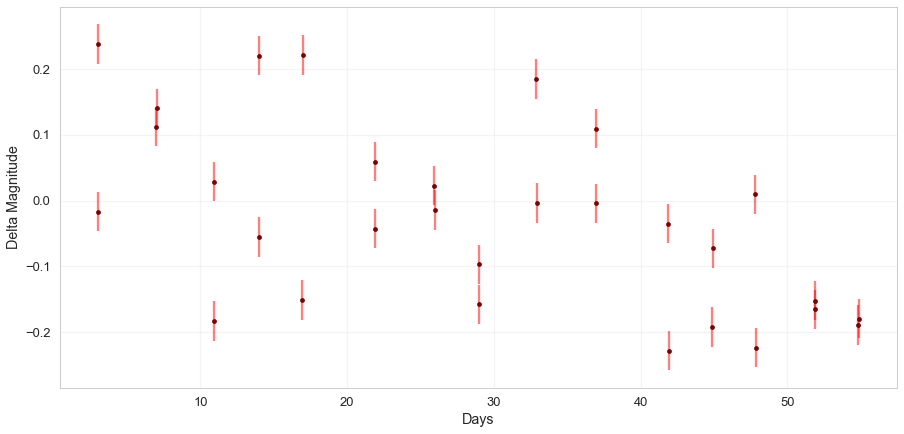

In [12]:
# Plot that last version, through all times
plt.figure(figsize=(15, 7))
plt.errorbar(times, mags, yerr=mag_errs, color='r', linestyle='', marker='.', alpha=0.5)
plt.plot(times, mags, 'k.')
plt.grid(True, alpha=0.2)
plt.xlabel('Days')
plt.ylabel('Delta Magnitude')

In [13]:
# Make new data, the same template, observed @ ZTF + LCO 
fudge = 3.0
ztf_times, ztf_mags, ztf_mag_errs, ztf_tm = simulate_ZTF(spline_template, fudge=fudge)
nperiods = np.ceil(ztf_times[-1] / period)

lco_times = np.arange(0, period, 2./60./24.) + (nperiods + 10) * period
lco_true_mags = spline_template(lco_times, fudge=fudge)
lco_mag_errs = np.random.normal(0, 0.01, size=len(lco_times))
lco_mags = lco_true_mags + lco_mag_errs

In [13]:
# Or read previously created data. 
import pandas as pd
with open('all_lc.txt', 'r') as lc:
    fudge = 3.0
    d = pd.read_table(lc, delim_whitespace=True)
    d.columns = ['Time', 'Mags', 'Mag_errs', 'TrueMag']
    ztf = d.query('Mag_errs == 0.03')
    ztf_times = ztf.Time.values
    ztf_mags = ztf.Mags.values
    ztf_mag_errs = ztf.Mag_errs.values
    ztf_tm = ztf.TrueMag.values
    lco = d.query('Mag_errs == 0.01')
    lco_times = lco.Time.values
    lco_mags = lco.Mags.values
    lco_mag_errs = lco.Mag_errs.values
    lco_true_mags = lco.TrueMag.values

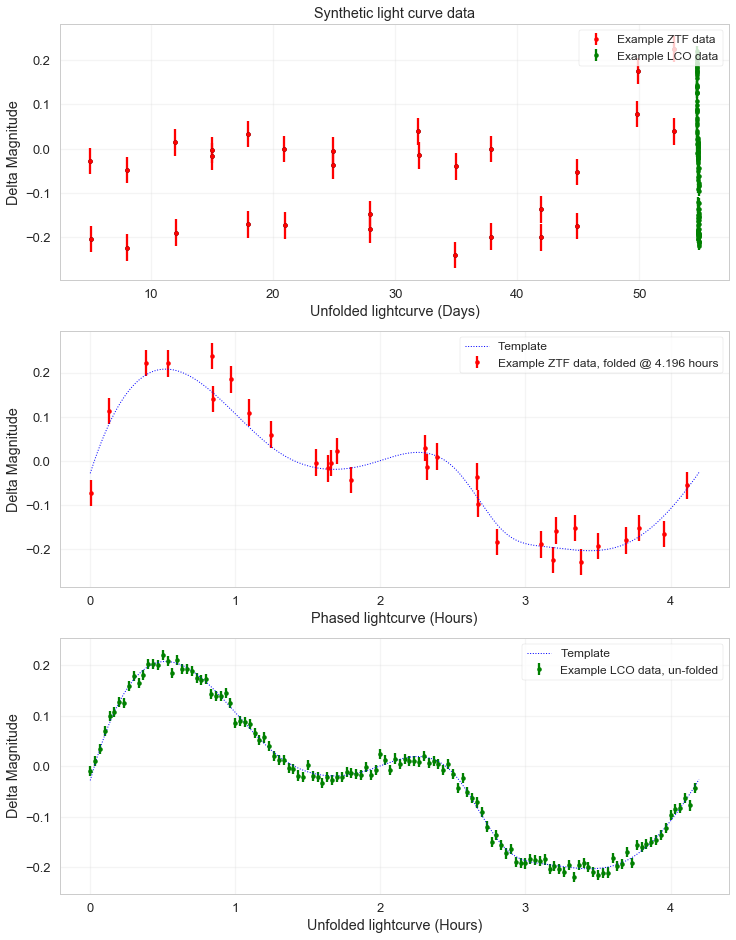

In [31]:
# New data, the same template, observed @ ZTF +_LCO for a continuous rotation period.
plt.figure(figsize=(12, 16))
# Plot both data sets unfolded
plt.subplot(3,1,1)
plt.title("Synthetic light curve data", fontsize='x-large')
plt.errorbar(ztf_times, ztf_mags, yerr=ztf_mag_errs, color='r', 
             linestyle='', marker='.', alpha=1.0,
            label='Example ZTF data')
plt.errorbar(lco_times, lco_mags, yerr=0.01, 
             color='g', linestyle='', marker='.', alpha=1.0,
            label='Example LCO data')
plt.plot(ztf_times, ztf_mags, 'k.')
plt.legend(loc='upper right', fancybox=True, fontsize='large', numpoints=1, frameon=True)
plt.grid(True, alpha=0.2)
plt.xlabel('Unfolded lightcurve (Days)', fontsize='x-large')
plt.ylabel('Delta Magnitude', fontsize='x-large')
# Plot ZTF folded
plt.subplot(3,1,2)
tt = np.arange(0, period, 1/24./60./60.0)
ff = spline_template(tt, fudge=fudge)
plt.plot(tt*24, ff, 'b', linewidth=1, linestyle=':', label='Template')
plt.errorbar((times % period)*24., mags, yerr=mag_errs, 
             color='r', linestyle='', marker='.', alpha=1.0,
            label='Example ZTF data, folded @ %.3f hours' % (period*24.0))
plt.legend(loc='upper right', fancybox=True, fontsize='large', numpoints=1, frameon=True)
plt.grid(True, alpha=0.2)
plt.xlabel('Phased lightcurve (Hours)', fontsize='x-large')
plt.ylabel('Delta Magnitude', fontsize='x-large')
# LCO alone
plt.subplot(3,1,3)
tt = np.arange(0, period, 1/24./60./60.0)
ff = spline_template(tt, fudge=fudge)
plt.plot(tt*24., ff, 'b', linewidth=1, linestyle=':', label='Template')
plt.errorbar((lco_times-lco_times[0])*24.0, lco_mags, yerr=0.01, 
             color='g', linestyle='', marker='.', alpha=1.0,
            label='Example LCO data, un-folded')
plt.legend(loc='upper right', fancybox=True, fontsize='large', numpoints=1, frameon=True)
plt.grid(True, alpha=0.2)
#plt.title('Example light curve at LCO', fontsize='x-large')
plt.xlabel('Unfolded lightcurve (Hours)', fontsize='x-large')
plt.ylabel('Delta Magnitude', fontsize='x-large')
plt.savefig('lco_lc.eps', format='eps')

In [15]:
# Write out exact data, if you like. 
with open('all_lc.txt', 'w') as wout:
    wout.write('Time(days) Mag Mag_err TrueMag\n')
    for zti, zmi, zmei, ztmi in zip(ztf_times, ztf_mags, ztf_mag_errs, ztf_tm):
        wout.write('%f %f %f %f\n' % (zti, zmi, zmei, ztmi))
    for lcti, lcmi, lctmi in zip(lco_times, lco_mags, lco_true_mags):
        wout.write('%f %f 0.01 %f\n' % (lcti, lcmi, lctmi))

In [16]:
modelLS = periodic.LombScargle(fit_period=True, Nterms=2, fit_offset=True)
modelLS.optimizer.set(period_range=(1.0/24.0, 9.0/24.0), first_pass_coverage=100)
modelLS.fit(ztf_times, ztf_mags, ztf_mag_errs)
modelSS = periodic.SuperSmoother(fit_period=True)
modelSS.optimizer.set(period_range=(1.0/24.0, 9.0/24.0), first_pass_coverage=50)
modelSS.fit(ztf_times, ztf_mags, ztf_mag_errs)
print(modelLS.best_period*24.0, modelSS.best_period*24.0)

Finding optimal frequency:
 - Estimated peak width = 0.131
 - Using 100 steps per peak; omega_step = 0.00131
 - User-specified period range:  0.042 to 0.38
 - Computing periods at 102084 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 50 steps
Finding optimal frequency:
 - Estimated peak width = 0.131
 - Using 50 steps per peak; omega_step = 0.00263
 - User-specified period range:  0.042 to 0.38
 - Computing periods at 51043 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 100 steps
4.19577512656 5.0885929817


In [19]:
# Get info for periodograms
periods = np.concatenate([np.arange(1.0/24.0, 4.0/24.0, 0.005/60./24.), np.arange(4.0/24.0, 4.2/24.0, 0.001/60/24.), np.arange(4.2/24.0, 9.0/24.0, 0.005/60/24.)])
powerLS = modelLS.score(periods)
powerSS = modelSS.score(periods)

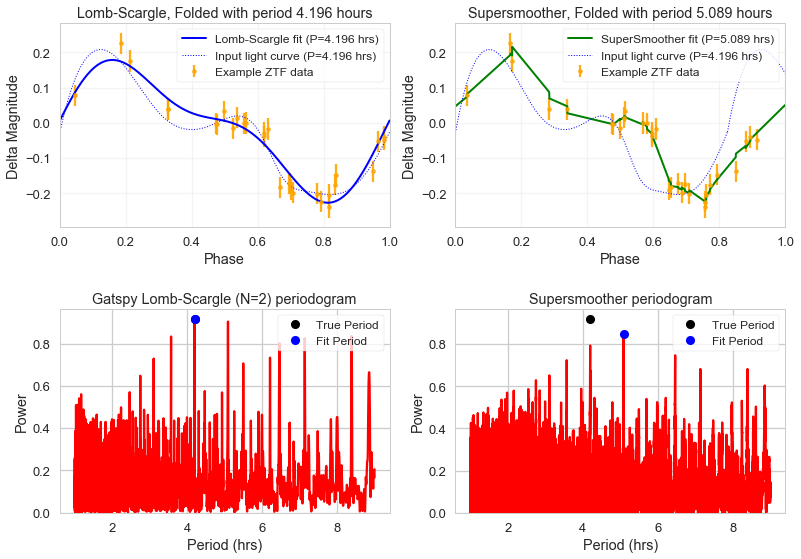

In [34]:
t = ztf_times
m = ztf_mags
me = ztf_mag_errs
plt.figure(figsize=(13, 9))
grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.4)
plt.subplot(grid[0, 0])
phase_period = modelLS.best_period
plt.title('Lomb-Scargle, Folded with period %.3f hours' % (phase_period*24.0), fontsize='x-large')
tt = np.arange(0, phase_period + 1/24.0/60/60, 1/24./60./60.0)
ff = modelLS.predict(tt)
plt.plot(tt/phase_period, ff, 'b', linewidth=2, linestyle='-', 
         label='Lomb-Scargle fit (P=%.3f hrs)' % (phase_period*24.0))
tt = np.arange(0, phase_period, 1/24./60./60.0)
ff = spline_template(tt, fudge=fudge)
nperiods = int(np.ceil(times.max()/period))
plt.plot(tt/phase_period, ff, 'b', linewidth=1, linestyle=':',
        label='Input light curve (P=%.3f hrs)' % (period*24.0))
plt.errorbar((t % phase_period)/phase_period, m, yerr=me, 
             color='orange', linestyle='', marker='.', alpha=0.9,
            label='Example ZTF data')
plt.legend(loc='upper right', fancybox=True, fontsize='large', numpoints=1, frameon=True)
plt.grid(True, alpha=0.2)
plt.xlabel('Phase', fontsize='x-large')
plt.xlim(0, 1)
plt.ylabel('Delta Magnitude', fontsize='x-large')
plt.subplot(grid[0, 1])
phase_period = modelSS.best_period
plt.title('Supersmoother, Folded with period %.3f hours' % (phase_period*24.0), fontsize='x-large')
tt = np.arange(0, phase_period + 1/24.0/60/60, 1/24./60./60.0)
ff = modelSS.predict(tt)
plt.plot(tt/phase_period, ff, 'g', linewidth=2, linestyle='-', 
         label='SuperSmoother fit (P=%.3f hrs)' % (phase_period*24.0))
tt = np.arange(0, phase_period, 1/24./60./60.0)
ff = spline_template(tt, fudge=fudge)
nperiods = int(np.ceil(times.max()/period))
plt.plot(tt/phase_period, ff, 'b', linewidth=1, linestyle=':',
        label='Input light curve (P=%.3f hrs)' % (period*24.0))
plt.errorbar((t % phase_period)/phase_period, m, yerr=me, 
             color='orange', linestyle='', marker='.', alpha=0.9,
            label='Example ZTF data')
plt.legend(loc='upper right', fancybox=True, fontsize='large', numpoints=1, frameon=True)
plt.grid(True, alpha=0.2)
plt.xlabel('Phase', fontsize='x-large')
plt.xlim(0, 1)
plt.ylabel('Delta Magnitude', fontsize='x-large')
plt.subplot(grid[1, 0])
plt.plot(periods*24, powerLS, 'r')
pp = modelLS.score(period)
plt.plot(period*24, pp, 'ko', label='True Period')
pp = modelLS.score(modelLS.best_period)
plt.plot(modelLS.best_period*24.0, pp, 'bo', label='Fit Period')
plt.legend(loc='upper right', fancybox=True, fontsize='large', numpoints=1, frameon=True)
plt.title('Gatspy Lomb-Scargle (N=2) periodogram', fontsize='x-large')
plt.xlabel('Period (hrs)', fontsize='x-large')
plt.ylabel('Power', fontsize='x-large')
plt.ylim(ymin=0)
plt.subplot(grid[1, 1])
plt.plot(periods*24, powerSS, 'r')
pp = modelLS.score(period)
plt.plot(period*24, pp, 'ko', label='True Period')
pp = modelSS.score(modelSS.best_period)
plt.plot(modelSS.best_period*24.0, pp, 'bo', label='Fit Period')
plt.legend(loc='upper right', fancybox=True, fontsize='large', numpoints=1, frameon=True)
plt.title('Supersmoother periodogram', fontsize='x-large')
plt.xlabel('Period (hrs)', fontsize='x-large')
plt.ylabel('Power', fontsize='x-large')
plt.ylim(ymin=0)
plt.savefig('LS-SS_fits.eps', format='eps')

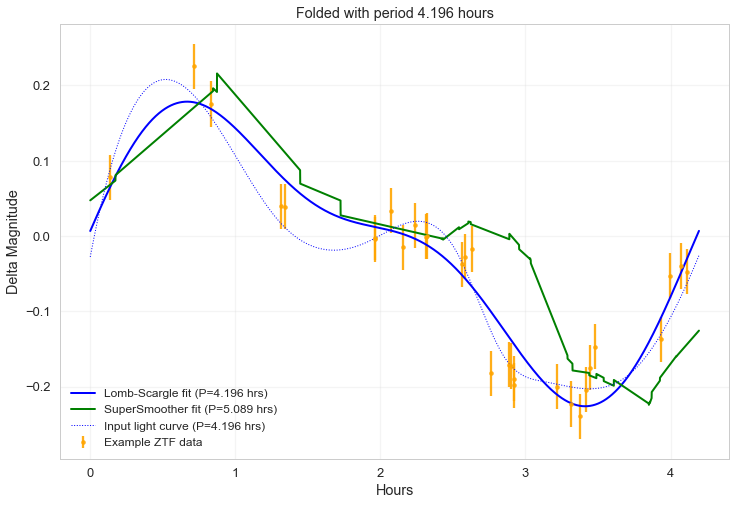

In [35]:
plt.figure(figsize=(12, 8))
phase_period = period
plt.title('Folded with period %.3f hours' % (phase_period*24.0), fontsize='x-large')
tt = np.arange(0, phase_period + 1./24/60/60, 1/24./60./60.0)
ff = modelLS.predict(tt)
plt.plot(tt*24., ff, 'b', linewidth=2, linestyle='-', 
         label='Lomb-Scargle fit (P=%.3f hrs)' % (modelLS.best_period*24.0))
tt = np.arange(0, phase_period + 1/24.0/60./60, 1/24./60./60.0)
ff = modelSS.predict(tt)
plt.plot(tt*24, ff, 'g', linewidth=2, linestyle='-', 
         label='SuperSmoother fit (P=%.3f hrs)' % (modelSS.best_period*24.0))
tt = np.arange(0, phase_period, 1/24./60./60.0)
ff = spline_template(tt, fudge=fudge)
nperiods = int(np.ceil(times.max()/period))
plt.plot(tt*24., ff, 'b', linewidth=1, linestyle=':',
        label='Input light curve (P=%.3f hrs)' % (period*24.0))
plt.errorbar((t % phase_period)*24., m, yerr=me, 
             color='orange', linestyle='', marker='.', alpha=0.9,
            label='Example ZTF data')
#plt.plot((t % phase_period)*24., tm, 'k.')
plt.legend(loc='upper right', fancybox=True, fontsize='large', numpoints=1)
plt.grid(True, alpha=0.2)
plt.xlabel('Hours')
plt.ylabel('Delta Magnitude')
plt.legend(loc='lower left', fancybox=True, fontsize='large', numpoints=1)
plt.grid(True, alpha=0.2)
plt.xlabel('Hours', fontsize='x-large')
plt.ylabel('Delta Magnitude', fontsize='x-large')
plt.savefig('fit_both.eps', format='eps')

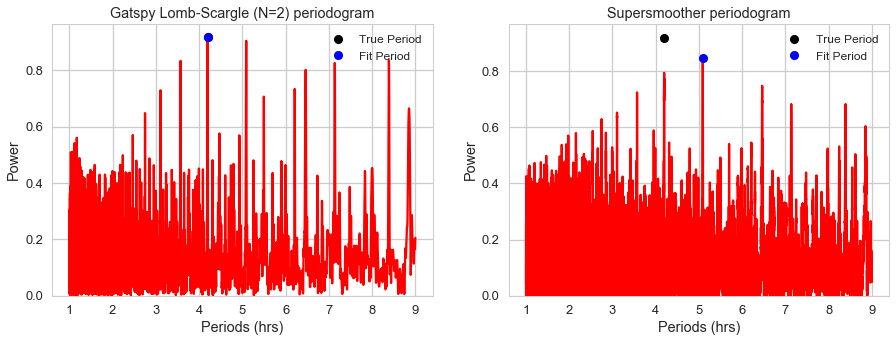

In [36]:
#Periodograms
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(periods*24, powerLS, 'r')
pp = modelLS.score(period)
plt.plot(period*24, pp, 'ko', label='True Period')
pp = modelLS.score(modelLS.best_period)
plt.plot(modelLS.best_period*24.0, pp, 'bo', label='Fit Period')
plt.legend(loc='upper right', fancybox=True, fontsize='large', numpoints=1)
plt.title('Gatspy Lomb-Scargle (N=2) periodogram', fontsize='x-large')
plt.xlabel('Periods (hrs)', fontsize='x-large')
plt.ylabel('Power', fontsize='x-large')
plt.ylim(ymin=0)
plt.subplot(1,2,2)
plt.plot(periods*24, powerSS, 'r')
pp = modelLS.score(period)
plt.plot(period*24, pp, 'ko', label='True Period')
pp = modelSS.score(modelSS.best_period)
plt.plot(modelSS.best_period*24.0, pp, 'bo', label='Fit Period')
plt.legend(loc='upper right', fancybox=True, fontsize='large', numpoints=1)
plt.title('Supersmoother periodogram', fontsize='x-large')
plt.xlabel('Periods (hrs)', fontsize='x-large')
plt.ylabel('Power', fontsize='x-large')
plt.ylim(ymin=0)
plt.savefig('LS-SS_periodogram.eps', format='eps')

[ 1.02833333] 0.556302605806 0.466904028391


(0, 0.76644311528770726)

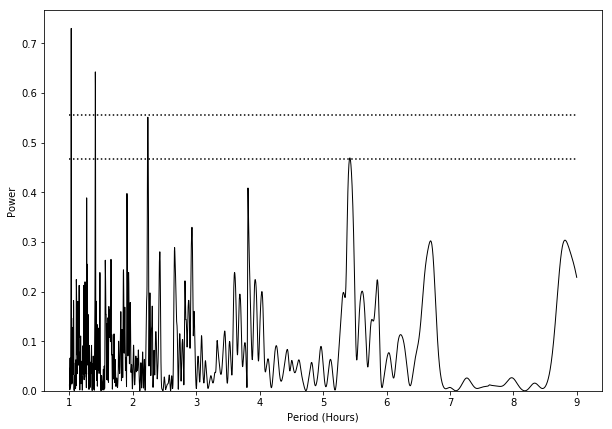

In [22]:
# Let's check the astroML version, with bootstrapping. Full range of periods that we covered above.
periods = np.arange(1.0/24.0, 9.0/24.0, 0.1/60./24.)
power = time_series.lomb_scargle(ztf_times, ztf_mags, ztf_mag_errs, 1./periods, 
                                 generalized=True)
D = time_series.lomb_scargle_bootstrap(ztf_times, ztf_mags, ztf_mag_errs, 1./periods, 
                                       generalized=True, N_bootstraps=1000)
sig1, sig5 = np.percentile(D, [99, 95])
print(periods[np.where(power==power.max())]*24.0, sig1, sig5)

plt.figure(figsize=(10, 7))
#plt.plot(periods*24.0, power)
plt.xlabel('Period (Hours)')
plt.ylabel('Power')
plt.plot(periods*24.0, power, '-', c='black', lw=1, zorder=1)
plt.plot([periods[0]*24.0, periods[-1]*24.0], [sig1, sig1], ':', c='black')
plt.plot([periods[0]*24.0, periods[-1]*24.0], [sig5, sig5], ':', c='black')
plt.ylim(ymin=0)

[ 5.42166667] 0.543020128172 0.441055442902


(0, 0.57017112143345694)

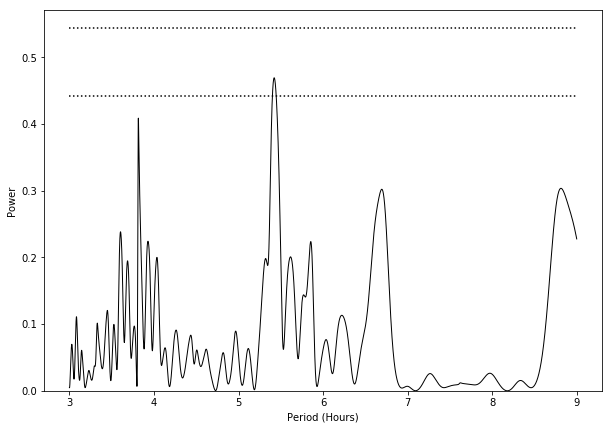

In [23]:
# Let's check the astroML version, with bootstrapping.
# -- but restrict the periods because we wouldn't believe super short periods
periods = np.arange(3.0/24.0, 9.0/24.0, 0.01/60./24.)
power = time_series.lomb_scargle(ztf_times, ztf_mags, ztf_mag_errs, 1./periods, 
                                 generalized=True)
D = time_series.lomb_scargle_bootstrap(ztf_times, ztf_mags, ztf_mag_errs, 1./periods, 
                                       generalized=True, N_bootstraps=1000)
sig1, sig5 = np.percentile(D, [99, 95])
print(periods[np.where(power==power.max())]*24.0, sig1, sig5)
plt.figure(figsize=(10, 7))
#plt.plot(periods*24.0, power)
plt.xlabel('Period (Hours)')
plt.ylabel('Power')
plt.plot(periods*24.0, power, '-', c='black', lw=1, zorder=1)
plt.plot([periods[0]*24.0, periods[-1]*24.0], [sig1, sig1], ':', c='black')
plt.plot([periods[0]*24.0, periods[-1]*24.0], [sig5, sig5], ':', c='black')
plt.ylim(ymin=0)

Finding optimal frequency:
 - Estimated peak width = 0.131
 - Using 10 steps per peak; omega_step = 0.0131
 - User-specified period range:  0.042 to 0.38
 - Computing periods at 10210 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 500 steps
4.19408961922


(0, 0.8760075729358614)

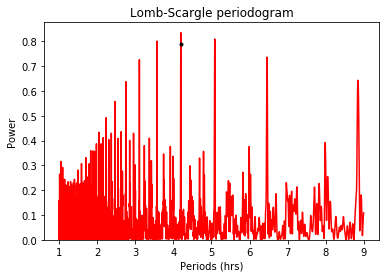

In [24]:
# Is that just because of single peak?  Or using astroML's LS?
modelLS1 = periodic.LombScargleAstroML(fit_period=True, Nterms=1, fit_offset=True)
modelLS1.optimizer.set(period_range=(1.0/24.0, 9.0/24.0), first_pass_coverage=10)
modelLS1.fit(ztf_times, ztf_mags, ztf_mag_errs)
print(modelLS1.best_period*24.0)
periods = np.arange(1.0/24.0, 9.0/24.0, 0.01/60./24.)
power = modelLS1.score(periods)
plt.plot(periods*24, power, 'r')
#periods = np.arange(3.9/24.0, 4.3/24.0, 0.001/60/24)
#power = modelLS.periodogram(periods)
#plt.plot(periods*24, power)
pp = modelLS1.score(period)
plt.plot(period*24, pp, 'k.')
plt.title('Lomb-Scargle periodogram')
plt.xlabel('Periods (hrs)')
plt.ylabel('Power')
plt.ylim(ymin=0)

My take on all this is that deciding when you've got a properly fit period is difficult. 

gatspy agrees, across the different methods -- probably because of the optimizer?
astroML's LS is different -- probably because of optimizer? maybe because of the period specification? 
 .. but completely different profile of power so? 


But what if you have different realizations of the ZTF light curve? Let's see some variation on the best-fit periods.

In [25]:
best_ls_periods = []
best_ss_periods = []
for i in range(25):
    t, m, me, tm = simulate_ZTF(spline_template, fudge=fudge)
    modelLS = periodic.LombScargle(fit_period=True, Nterms=2, fit_offset=True)
    modelLS.optimizer.set(period_range=(1.0/24.0, 9.0/24.0), first_pass_coverage=100)
    modelLS.fit(t, m, me)
    best_ls_periods.append(modelLS.best_period*24.0)
    modelSS = periodic.SuperSmoother(fit_period=True)
    modelSS.optimizer.set(period_range=(1.0/24.0, 9.0/24.0), first_pass_coverage=50)
    modelSS.fit(t, m, me)
    best_ss_periods.append(modelSS.best_period*24.0)

Finding optimal frequency:
 - Estimated peak width = 0.107
 - Using 100 steps per peak; omega_step = 0.00107
 - User-specified period range:  0.042 to 0.38
 - Computing periods at 125529 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 45 steps
Finding optimal frequency:
 - Estimated peak width = 0.107
 - Using 50 steps per peak; omega_step = 0.00214
 - User-specified period range:  0.042 to 0.38
 - Computing periods at 62765 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 95 steps
Finding optimal frequency:
 - Estimated peak width = 0.126
 - Using 100 steps per peak; omega_step = 0.00126
 - User-specified period range:  0.042 to 0.38
 - Computing periods at 106508 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 50 steps
Finding optimal frequency:
 - Estimated peak width = 0.126
 - Using 50 steps per peak; omega_step = 0.00252
 - User-specified period range:  0.042 to 0.38
 - Computing periods at 53255 steps
Zooming-in on 5 candidate peaks:
 

4.19618744965 4.19621238711
4.19602142551 3.56986966493
4.19624722262 4.19616396637
4.19594951155 4.19594951155
4.19555756669 4.19553030828
4.19596818403 3.56940418885
4.19610285206 4.19613166549
4.19613366334 4.19587104603
4.19598913813 4.19633028425
4.19581347709 4.19610212729
4.19639713829 4.19664211162
4.19602118164 4.19594377115
4.19597641682 4.19586950865
3.56994158832 4.19585491685
4.19637343667 4.19621851697
4.19581528712 4.19586976432
4.19651107231 4.19569987588
4.19578881645 4.1957085337
4.19598765431 4.19648710802
4.19601346928 5.08774155734
4.19572762411 4.1955013198
4.1963156912 4.19626494002
4.19604919442 4.19564400752
4.19602610854 4.19571096165
4.19617924502 4.19649444071


Text(0,0.5,'Supersmoother period (hours)')

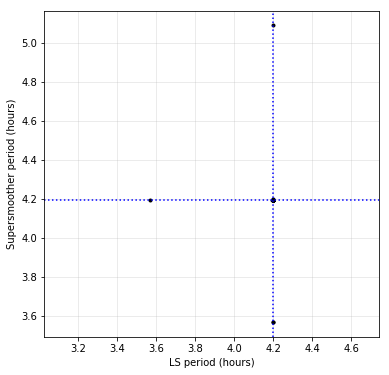

In [26]:
for l, s in zip(best_ls_periods, best_ss_periods):
    print(l, s)
plt.figure(figsize=(6,6))
plt.plot(best_ls_periods, best_ss_periods, 'k.')
plt.grid(True, alpha=0.3)
plt.axvline(period*24.0, linestyle=':', color='b')
plt.axhline(period*24.0, linestyle=':', color='b')
plt.gca().set_aspect('equal', 'datalim')
plt.xlabel('LS period (hours)')
plt.ylabel('Supersmoother period (hours)')

Text(0,0.5,'Delta Magnitude')

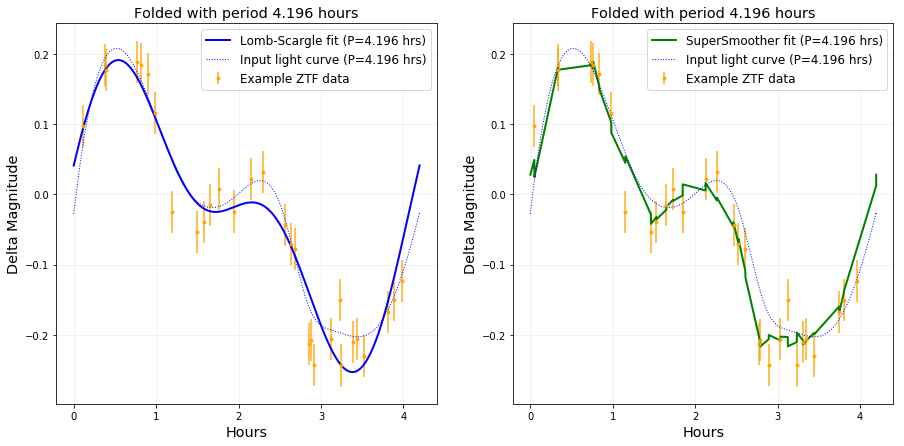

In [27]:
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
phase_period = modelLS.best_period
plt.title('Folded with period %.3f hours' % (phase_period*24.0), fontsize='x-large')
tt = np.arange(0, phase_period + 1/24.0/60/60, 1/24./60./60.0)
ff = modelLS.predict(tt)
plt.plot(tt*24., ff, 'b', linewidth=2, linestyle='-', 
         label='Lomb-Scargle fit (P=%.3f hrs)' % (phase_period*24.0))
tt = np.arange(0, phase_period, 1/24./60./60.0)
ff = spline_template(tt, fudge=fudge)
nperiods = int(np.ceil(times.max()/period))
plt.plot(tt*24., ff, 'b', linewidth=1, linestyle=':',
        label='Input light curve (P=%.3f hrs)' % (period*24.0))
plt.errorbar((t % phase_period)*24., m, yerr=me, 
             color='orange', linestyle='', marker='.', alpha=0.9,
            label='Example ZTF data')
plt.legend(loc='upper right', fancybox=True, fontsize='large', numpoints=1)
plt.grid(True, alpha=0.2)
plt.xlabel('Hours', fontsize='x-large')
plt.ylabel('Delta Magnitude', fontsize='x-large')
plt.subplot(1,2,2)
phase_period = modelSS.best_period
plt.title('Folded with period %.3f hours' % (phase_period*24.0), fontsize='x-large')
tt = np.arange(0, phase_period + 1/24.0/60/60, 1/24./60./60.0)
ff = modelSS.predict(tt)
plt.plot(tt*24, ff, 'g', linewidth=2, linestyle='-', 
         label='SuperSmoother fit (P=%.3f hrs)' % (phase_period*24.0))
tt = np.arange(0, phase_period, 1/24./60./60.0)
ff = spline_template(tt, fudge=fudge)
nperiods = int(np.ceil(times.max()/period))
plt.plot(tt*24., ff, 'b', linewidth=1, linestyle=':',
        label='Input light curve (P=%.3f hrs)' % (period*24.0))
plt.errorbar((t % phase_period)*24., m, yerr=me, 
             color='orange', linestyle='', marker='.', alpha=0.9,
            label='Example ZTF data')
plt.legend(loc='upper right', fancybox=True, fontsize='large', numpoints=1)
plt.grid(True, alpha=0.2)
plt.xlabel('Hours', fontsize='x-large')
plt.ylabel('Delta Magnitude', fontsize='x-large')
#plt.savefig('LS-SS_fits.png', format='png')

Text(0,0.5,'Delta Magnitude')

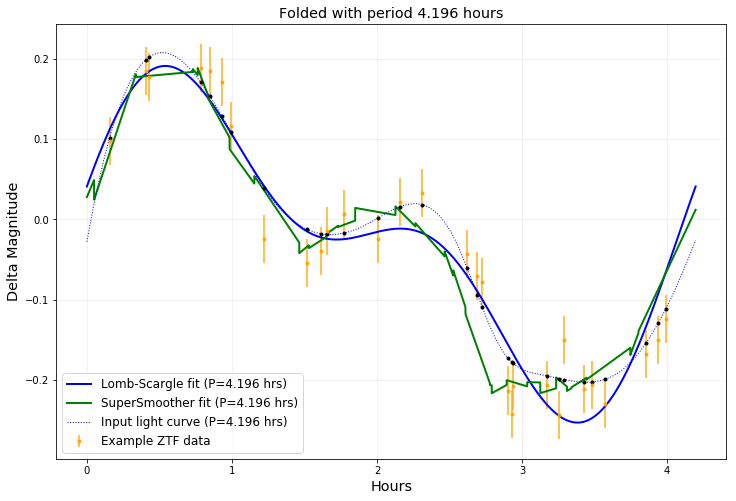

In [28]:
plt.figure(figsize=(12, 8))
phase_period = period
plt.title('Folded with period %.3f hours' % (phase_period*24.0), fontsize='x-large')
tt = np.arange(0, phase_period + 1./24/60/60, 1/24./60./60.0)
ff = modelLS.predict(tt)
plt.plot(tt*24., ff, 'b', linewidth=2, linestyle='-', 
         label='Lomb-Scargle fit (P=%.3f hrs)' % (modelLS.best_period*24.0))
tt = np.arange(0, phase_period + 1/24.0/60./60, 1/24./60./60.0)
ff = modelSS.predict(tt)
plt.plot(tt*24, ff, 'g', linewidth=2, linestyle='-', 
         label='SuperSmoother fit (P=%.3f hrs)' % (modelSS.best_period*24.0))
tt = np.arange(0, phase_period, 1/24./60./60.0)
ff = spline_template(tt, fudge=fudge)
nperiods = int(np.ceil(times.max()/period))
plt.plot(tt*24., ff, 'b', linewidth=1, linestyle=':',
        label='Input light curve (P=%.3f hrs)' % (period*24.0))
plt.errorbar((t % phase_period)*24., m, yerr=me, 
             color='orange', linestyle='', marker='.', alpha=0.9,
            label='Example ZTF data')
plt.plot((t % phase_period)*24., tm, 'k.')
plt.legend(loc='upper right', fancybox=True, fontsize='large', numpoints=1)
plt.grid(True, alpha=0.2)
plt.xlabel('Hours')
plt.ylabel('Delta Magnitude')
plt.legend(loc='lower left', fancybox=True, fontsize='large', numpoints=1)
plt.grid(True, alpha=0.2)
plt.xlabel('Hours', fontsize='x-large')
plt.ylabel('Delta Magnitude', fontsize='x-large')